# Data Wizard Take Home Exercise - Assignment Part 1
Author: Giacomo Dalla Chiara

In [25]:
rm(list=ls()) #clean the console
library(ggplot2) #package used for plotting
library(repr) #package used to control plot size in jn

## Synthetic data generation

In this first step, I generate a synthetic dataset of 1000 trips performed by 50 drivers. Each observation is a trip, characterized by the following variables:
- driver_id: assuming we have 50 unique driver IDs
- time_of_day: assuming we have data from midnight (0) to 11 pm (23)
- pick_up_date: we assume data is from a week in February 2023
- earnings_pay: assuming earnings are exponentially distributed with rate=1 (parameter of the exp distirbution)
- day_of_week: Monday, Tuesday, ...
- special_event: =1 whenever a trip is considered belonging to a "special event", e.g. a sport event

Generating a synthetic dataset can help better understand how different models behave under certain conditions (e.g. extreme values). Synthetic data can also be useful for simulation (e.g. we could simulate a entire population of drivers, or simulate drivers in a location we have little data) if it is well calibrated.

In [26]:
job <- data.frame("driver_id"=sample(1:50, 1000, replace=TRUE),
                  "time_of_day"=sample(0:23, 1000, replace=TRUE), 
                  "pick_up_date"=sample(seq(as.Date("2023/02/13"), as.Date("2023/02/19"), by="day"), 1000, replace=T),
                  "earnings_pay"=rexp(1000, rate = 0.045)) 

# Adding day of the week in chr
job$day_of_week <- weekdays(job$pick_up_date) 

# Adding special events (e.g. super bowl)
job$special_event <- 0
job[c(1,50,467,835,456,23,788),"special_event"] <- 1
job[c(1,50,467,835,456,23,788),"earnings_pay"] <- job[c(1,50,467,835,456,23,788),"earnings_pay"]+400 #I'm adding $400 to earnings obtained during special events

str(job)

'data.frame':	1000 obs. of  6 variables:
 $ driver_id    : int  38 3 44 15 49 22 23 1 8 15 ...
 $ time_of_day  : int  10 12 10 18 4 15 21 15 16 18 ...
 $ pick_up_date : Date, format: "2023-02-15" "2023-02-18" ...
 $ earnings_pay : num  417.1 36.2 12.4 21.2 28 ...
 $ day_of_week  : chr  "Wednesday" "Saturday" "Thursday" "Thursday" ...
 $ special_event: num  1 0 0 0 0 0 0 0 0 0 ...


## V0. Non parametric model: mean

In the first model V0, I eastimate average hourly pay using the mean function

In [27]:
avg_pay <- aggregate(job$earnings_pay, list(job$time_of_day, job$day_of_week), FUN=mean)
names(avg_pay) <- c("time_of_day", "day_of_week", "value_mean")

Then, I use ggplot to create a heatmap of the mean hourly pay

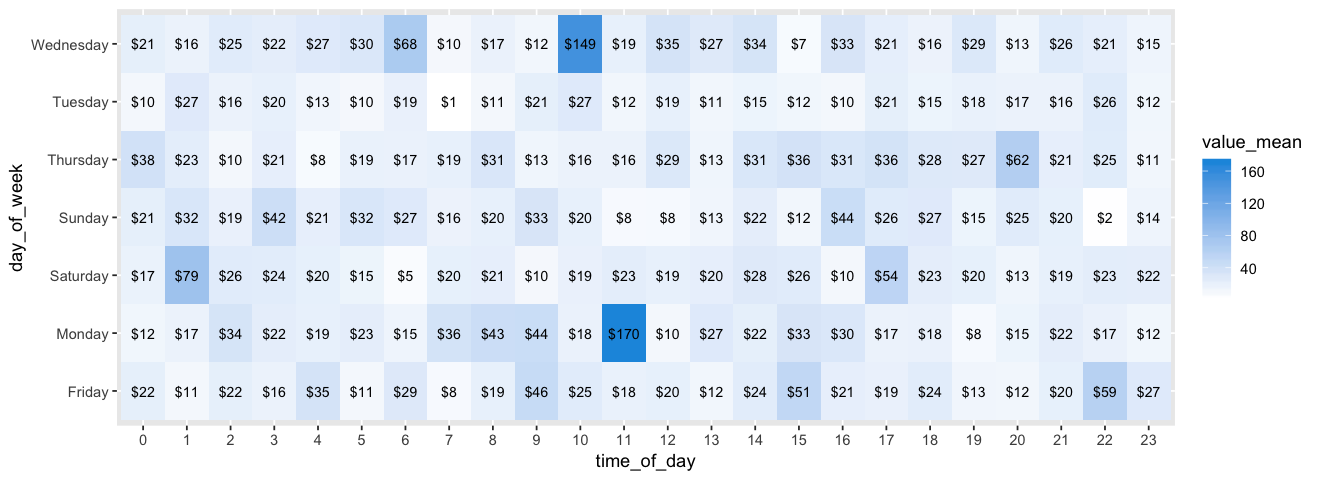

In [28]:
avg_pay$lab_mean <- paste0("$",as.character(floor(avg_pay$value_mean)))
avg_pay$time_of_day <- as.factor(avg_pay$time_of_day)
hm <- ggplot(avg_pay, aes(time_of_day, day_of_week)) +
      geom_tile(aes(fill = value_mean)) +
      geom_text(aes(label = lab_mean), size=3) +
      scale_fill_gradient(low = "white", high = "#1b98e0")
options(repr.plot.width=11, repr.plot.height=4)
hm